# PPI analysis
- As suggested, using PPI analysis to show that coupling of amg-hippocampus is higher in CS+US compared to other
- Taken from: https://dartbrains.org/content/Connectivity.html

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import nilearn
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import zscore, fdr, one_sample_permutation
from nltools.file_reader import onsets_to_dm
from nltools.plotting import component_viewer
from scipy.stats import binom, ttest_1samp
from sklearn.metrics import pairwise_distances
from copy import deepcopy
import networkx as nx
from nilearn.plotting import plot_stat_map, view_img_on_surf
import nibabel as nib

# stats
from scipy import stats
import pingouin as pg

/gpfs/ysm/project/joormann/oad4/conda_envs/naturalistic/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
output_dir = '/gpfs/gibbs/pi/levy_ifat/Or/RV_FC'

/gpfs/ysm/project/joormann/oad4/conda_envs/naturalistic/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
# get relevant subjects first
df = pd.read_csv('../scr_amg_hipp_all.csv')
subject_list = df['sub'].unique()
subject_list

array(['sub-189', 'sub-205', 'sub-071', 'sub-204', 'sub-085', 'sub-100',
       'sub-132', 'sub-185', 'sub-167', 'sub-043', 'sub-062', 'sub-073',
       'sub-082', 'sub-030', 'sub-160', 'sub-196', 'sub-1223', 'sub-169',
       'sub-1222', 'sub-055', 'sub-170', 'sub-047', 'sub-177', 'sub-130',
       'sub-172', 'sub-200', 'sub-173', 'sub-026', 'sub-059', 'sub-072',
       'sub-1232', 'sub-166', 'sub-032', 'sub-016', 'sub-1205', 'sub-186',
       'sub-056', 'sub-053', 'sub-150', 'sub-065', 'sub-154', 'sub-193',
       'sub-165', 'sub-103', 'sub-168', 'sub-102', 'sub-048', 'sub-027',
       'sub-182', 'sub-202', 'sub-203', 'sub-066', 'sub-038', 'sub-184',
       'sub-171', 'sub-179', 'sub-153', 'sub-144', 'sub-178', 'sub-063',
       'sub-010', 'sub-158', 'sub-083', 'sub-126', 'sub-152'],
      dtype=object)

In [4]:
# load timeseries (to grab amygdala ts)
sub_arr = np.load('../sub_55.npy', allow_pickle=True)
ts_arr = np.load('../array_55.npy', allow_pickle=True)

In [81]:
# get index of subject location
idx = np.where(sub_arr=="sub-189")[0][0]
# grab that subjects amygdala ts
idx
amg = ts_arr[idx][:,20] # ROI 20 in DiFuMo is the amygdala

In [36]:
amg.shape

(552,)

In [37]:
# grab cleaned functional and events file for each subject
# templates
func_file = '/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/{sub}_ses-1_denoise_smooth6mm_task-RV_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
events_file = '/gpfs/gibbs/pi/levy_ifat/Or/RV_FSL/eventfiles/{sub}.csv'

In [62]:
#test on one subject

sub = 'sub-189'

func = func_file.format(sub=sub)
event = events_file.format(sub=sub)
# load data to compare later

smoothed = Brain_Data(func)

tr=2
n_tr = nib.load(func).shape[-1]

onsets = pd.read_csv(event, sep=',')
onsets.columns = ['Stim', 'Onset', 'Duration']

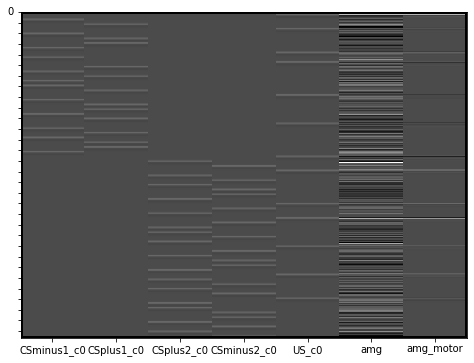

In [63]:
dm = onsets_to_dm(onsets, sampling_freq=1/tr, run_length=n_tr)
us_variables = ['CSplusUS1', 'CSminusUS2']
ppi_dm = dm.drop(us_variables, axis=1)
ppi_dm['US'] = pd.Series(dm.loc[:, us_variables].sum(axis=1))
ppi_dm_conv = ppi_dm.convolve()
ppi_dm_conv['amg'] = amg
ppi_dm_conv['amg_motor'] = ppi_dm_conv['amg']*ppi_dm_conv['US_c0']
dm = Design_Matrix(pd.concat([ppi_dm_conv], axis=1), sampling_freq=1/tr)
#dm = dm.add_poly(order=2, include_lower=True)

#dm.heatmap()

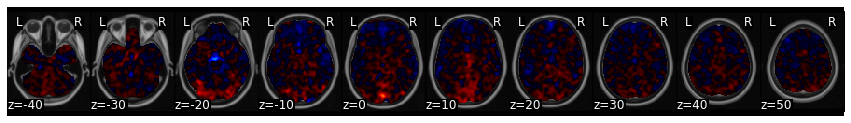

In [72]:
smoothed.X = dm
ppi_stats = smoothed.regress()
amg_US_ppi = ppi_stats['beta'][int(np.where(smoothed.X.columns=='amg_motor')[0][0])]
#amg_US_ppi.plot()
amg_US_ppi.to_nifti()

In [70]:
np.where(smoothed.X.columns=='amg_motor')

(array([6]),)

In [74]:
amg_US_ppi.to_nifti()

# Running PPI on the entire subjects list
- This cell was ran once, so data already there

In [82]:
# templates
func_file = '/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/{sub}_ses-1_denoise_smooth6mm_task-RV_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
events_file = '/gpfs/gibbs/pi/levy_ifat/Or/RV_FSL/eventfiles/{sub}.csv'
# # run group analysis
# for sub in subject_list:
#     print(f'Running {sub}')
#     # grab functional files
#     func = func_file.format(sub=sub)
#     event = events_file.format(sub=sub)
    
#     # grab amygdala timeseries
#     idx = np.where(sub_arr==sub)[0][0]
#     # grab that subjects amygdala ts
#     amg = ts_arr[idx][:,20] # ROI 20 in DiFuMo is the amygdala
#     # load data to compare later
#     smoothed = Brain_Data(func)
#     tr=2
#     n_tr = nib.load(func).shape[-1]
#     onsets = pd.read_csv(event, sep=',')
#     onsets.columns = ['Stim', 'Onset', 'Duration']
#     dm = onsets_to_dm(onsets, sampling_freq=1/tr, run_length=n_tr)
#     us_variables = ['CSplusUS1', 'CSminusUS2']
#     ppi_dm = dm.drop(us_variables, axis=1)
#     ppi_dm['US'] = pd.Series(dm.loc[:, us_variables].sum(axis=1))
#     ppi_dm_conv = ppi_dm.convolve()
#     ppi_dm_conv['amg'] = amg
#     ppi_dm_conv['amg_motor'] = ppi_dm_conv['amg']*ppi_dm_conv['US_c0']
#     dm = Design_Matrix(pd.concat([ppi_dm_conv], axis=1), sampling_freq=1/tr)
#     smoothed.X = dm
#     ppi_stats = smoothed.regress()
#     ppi_stats['beta'].write(f'/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/ppi/{sub}_betas_ppi.nii.gz')
#     ppi_stats['beta'][int(np.where(smoothed.X.columns=='amg_motor')[0][0])].write(f'/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/ppi/{sub}_amg_UScontrast_ppi.nii.gz')
    

## Whole brain

In [5]:
#con1_name = 'horizontal_checkerboard'
con1_file_list = glob.glob(os.path.join('/gpfs/gibbs/pi/levy_ifat/Or/RV_FC/ppi/*_amg_UScontrast_ppi.nii.gz'))
con1_file_list.sort()
#print(con1_file_list)
con1_dat = Brain_Data(con1_file_list)
con1_stats = con1_dat.ttest()
#con1_stats['t'].iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

In [85]:
con1_stats = con1_dat.ttest(threshold_dict={'fdr':.05})
con1_stats['thr_t'].iplot()

interactive(children=(FloatText(value=0.0, description='Threshold'), HTML(value='Image is 3D', description='Vo…

## Posterior hippocampus

In [6]:
# grab difumo atlas
a = nilearn.datasets.fetch_atlas_difumo(dimension=256)
mask = Brain_Data(a.maps)
# binarize the mask
mask_bin = mask.threshold(upper=.0001, binarize=True)

/gpfs/ysm/project/joormann/oad4/conda_envs/naturalistic/lib/python3.7/site-packages/numpy/lib/npyio.py:2407: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


Ttest_1sampResult(statistic=3.6721156256233347, pvalue=0.0004927996503770807)

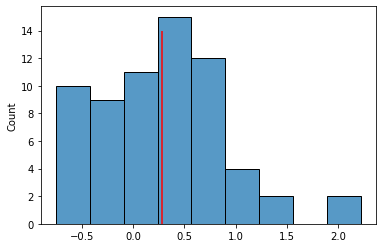

In [16]:
# grab posterior hippocampus (ROI 94)
%matplotlib inline
postHipp = con1_dat.extract_roi(mask=mask_bin[94])

sns.histplot(postHipp)
plt.vlines(x=np.mean(postHipp), ymin=0, ymax=14, color='red')
stats.ttest_1samp(postHipp, 0)

Ttest_1sampResult(statistic=-2.0652186732317666, pvalue=0.042957714661439036)

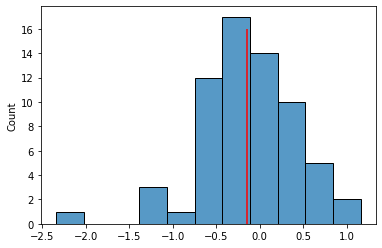

In [17]:
# test vmpfc
vmpfc = con1_dat.extract_roi(mask=mask_bin[42])
sns.histplot(vmpfc)
plt.vlines(x=np.mean(vmpfc), ymin=0, ymax=16, color='red')
stats.ttest_1samp(vmpfc, 0)

Ttest_1sampResult(statistic=1.8999382337708675, pvalue=0.061948433710020415)

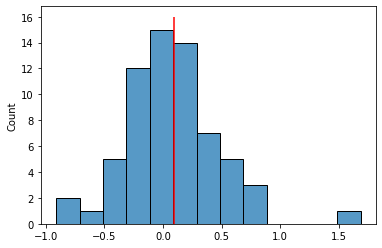

In [18]:
# anterior hippocampus
antHipp = con1_dat.extract_roi(mask=mask_bin[167])
sns.histplot(antHipp)
plt.vlines(x=np.mean(antHipp), ymin=0, ymax=16, color='red')
stats.ttest_1samp(antHipp, 0)

Ttest_1sampResult(statistic=-0.8864591934959015, pvalue=0.37868905760765725)

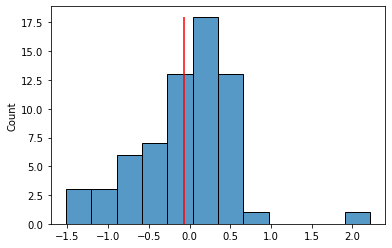

In [19]:
# control region (supramarginal left)
supra = con1_dat.extract_roi(mask=mask_bin[21])
sns.histplot(supra)
plt.vlines(x=np.mean(supra), ymin=0, ymax=18, color='red')
stats.ttest_1samp(supra, 0)

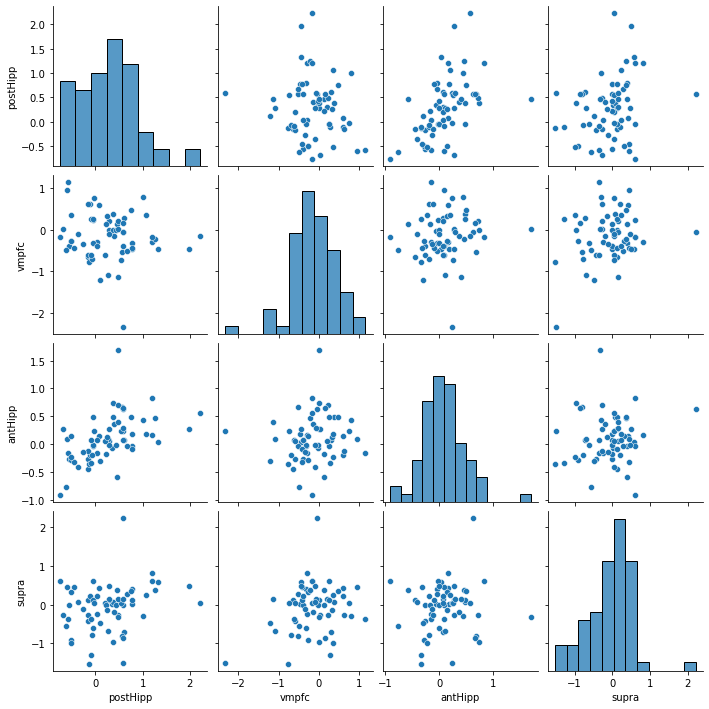

In [21]:
# combine all to dataset
d = pd.DataFrame({'postHipp': postHipp, 'vmpfc':vmpfc, 'antHipp':antHipp, 'supra':supra})
sns.pairplot(d)

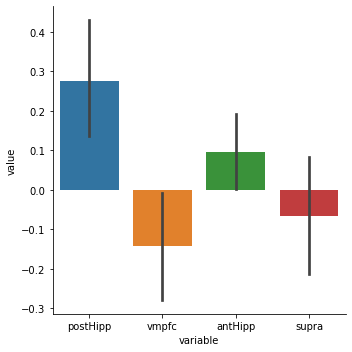

In [29]:
sns.catplot(x='variable', y='value', data=d.melt(), kind='bar')
plt.savefig('ppi_results.png')